# **Trabalho Inteligência de Negócios - 2024/01**

## 1. Informações Gerais
**Título:** Manutenção Preditiva de Rolamentos de Parafuso (NASA)

**Integrantes:**
  - Pedro H. P. Fontana
  - José Guilherme
  - Lucas Fidalgo

**Data:** 28/05/2024

**Disciplinas:** Inteligência de Negócios - 2024/01

## 1.1 Descrição do Estudo
O Projeto tem como objetivo fazer um estudo de manutenção preditiva aplicado a instrumentos mecânicos, bem como simular todo pipeline de dados que desde a coleta dos dados até a implementação. 

**Banco de Dados**:

Este banco de dados documenta testes até a falha de quatro rolamentos instalados em um eixo, mantido a 2000 RPM com uma carga radial de 6000 libras. Três conjuntos de dados estão incluídos, cada um contendo arquivos de sinais de vibração gravados em intervalos específicos:

**Conjunto 1**: 
   - Duração: 22/10/2003 a 25/11/2003
   - Arquivos: 2.156
   - Canais: 8 (2 por rolamento)
   - Intervalo de gravação: 10 minutos (5 minutos para os primeiros 43 arquivos)
   - Falhas: Pista interna no rolamento 3 e elemento rolante no rolamento 4.

**Conjunto 2**: 
   - Duração: 12/02/2004 a 19/02/2004
   - Arquivos: 984
   - Canais: 4 (1 por rolamento)
   - Intervalo de gravação: 10 minutos
   - Falha: Pista externa no rolamento 1.

**Conjunto 3**: 
   - Duração: 04/03/2004 a 04/04/2004
   - Arquivos: 4.448
   - Canais: 4 (1 por rolamento)
   - Intervalo de gravação: 10 minutos
   - Falha: Pista externa no rolamento 3.

Os dados foram coletados usando acelerômetros de quartzo e estão disponíveis em formato ASCII. 

**Referencias**:

J. Lee, H. Qiu, G. Yu, J. Lin, e Rexnord Technical Services (2007). IMS, Universidade de Cincinnati. "Conjunto de Dados de Rolamentos", Repositório de Dados de Prognósticos da NASA Ames (http://ti.arc.nasa.gov/project/prognostic-data-repository), Centro de Pesquisa Ames da NASA, Moffett Field, CA.

In [1]:
# Importing libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import abs, input_file_name, regexp_extract, to_timestamp, date_format, mean

In [2]:
# Create a SparkSession
spark = SparkSession\
        .builder\
        .appName("Bearing Data Processing")\
        .getOrCreate()


24/05/28 21:44:31 WARN Utils: Your hostname, Pedros-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.105 instead (on interface en0)
24/05/28 21:44:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/28 21:44:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [19]:
# Load the data
df = spark.read.csv(path="../data/raw/2nd_test/2nd_test", sep="\t", inferSchema=True)

# Show the data
df.show()


+------+------+------+------+
|   _c0|   _c1|   _c2|   _c3|
+------+------+------+------+
|-0.049|-0.071|-0.132| -0.01|
|-0.042|-0.073|-0.007|-0.105|
| 0.015|   0.0| 0.007|   0.0|
|-0.051|  0.02|-0.002|   0.1|
|-0.107|  0.01| 0.127| 0.054|
|-0.078|-0.212| 0.042|-0.044|
| -0.02| -0.01|-0.144|-0.007|
|-0.046| 0.112| 0.034| 0.034|
|-0.063|-0.154| 0.071| 0.076|
| 0.068| 0.044|-0.029| 0.054|
| 0.095| 0.022| -0.09|-0.037|
|-0.007| 0.007|-0.024|-0.095|
|-0.046|   0.0|-0.122|-0.059|
| 0.044|-0.002|-0.068| 0.027|
| 0.137| 0.007| 0.054| 0.073|
| 0.098|-0.032| 0.088|-0.029|
| 0.081|-0.081| -0.09|-0.105|
|-0.073| 0.042|-0.137|-0.083|
|-0.037| 0.037|  0.02|-0.015|
| 0.012| -0.02| 0.176|-0.005|
+------+------+------+------+
only showing top 20 rows



In [20]:
# Define column names
columns = ['bearing_1', 'bearing_2', 'bearing_3', 'bearing_4']

# Change the column names
for i, column_name in enumerate(columns):
    df = df.withColumnRenamed(f'_c{i}', column_name)

# Show the data
df.printSchema()


root
 |-- bearing_1: double (nullable = true)
 |-- bearing_2: double (nullable = true)
 |-- bearing_3: double (nullable = true)
 |-- bearing_4: double (nullable = true)



In [21]:
# Add a column with the input file name
df = df.withColumn("timestamp", input_file_name())

# Extract the base name of the file from the path
filename_col = regexp_extract(df['timestamp'], '([^/]+$)', 1)
df = df.withColumn("timestamp", filename_col)

# Define the custom datetime format for conversion
datetime_format = "yyyy.MM.dd.HH.mm.ss"

# Convert datetime column to timestamp
df = df.withColumn("timestamp", to_timestamp("timestamp", datetime_format))

# Show the DataFrame with formatted date column
df.show()


+---------+---------+---------+---------+-------------------+
|bearing_1|bearing_2|bearing_3|bearing_4|          timestamp|
+---------+---------+---------+---------+-------------------+
|   -0.049|   -0.071|   -0.132|    -0.01|2004-02-12 10:32:39|
|   -0.042|   -0.073|   -0.007|   -0.105|2004-02-12 10:32:39|
|    0.015|      0.0|    0.007|      0.0|2004-02-12 10:32:39|
|   -0.051|     0.02|   -0.002|      0.1|2004-02-12 10:32:39|
|   -0.107|     0.01|    0.127|    0.054|2004-02-12 10:32:39|
|   -0.078|   -0.212|    0.042|   -0.044|2004-02-12 10:32:39|
|    -0.02|    -0.01|   -0.144|   -0.007|2004-02-12 10:32:39|
|   -0.046|    0.112|    0.034|    0.034|2004-02-12 10:32:39|
|   -0.063|   -0.154|    0.071|    0.076|2004-02-12 10:32:39|
|    0.068|    0.044|   -0.029|    0.054|2004-02-12 10:32:39|
|    0.095|    0.022|    -0.09|   -0.037|2004-02-12 10:32:39|
|   -0.007|    0.007|   -0.024|   -0.095|2004-02-12 10:32:39|
|   -0.046|      0.0|   -0.122|   -0.059|2004-02-12 10:32:39|
|    0.0

In [22]:
df.printSchema()

root
 |-- bearing_1: double (nullable = true)
 |-- bearing_2: double (nullable = true)
 |-- bearing_3: double (nullable = true)
 |-- bearing_4: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [23]:
# Calculate the mean of the absolute values of bearing data grouped by timestamp
df = df.groupBy("timestamp").agg(
    mean(abs(df["bearing_1"])).alias("bearing_1"),
    mean(abs(df["bearing_2"])).alias("bearing_2"),
    mean(abs(df["bearing_3"])).alias("bearing_3"),
    mean(abs(df["bearing_4"])).alias("bearing_4")
).orderBy("timestamp")

# Show the DataFrame with the calculated mean values
df.show()

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=41314Kb max_used=41332Kb free=89757Kb
 bounds [0x00000001089e0000, 0x000000010b290000, 0x00000001109e0000]
 total_blobs=15109 nmethods=14174 adapters=845
 compilation: disabled (not enough contiguous free space left)


+-------------------+--------------------+-------------------+-------------------+--------------------+
|          timestamp|           bearing_1|          bearing_2|          bearing_3|           bearing_4|
+-------------------+--------------------+-------------------+-------------------+--------------------+
|2004-02-12 10:32:39| 0.05833242187500013|0.07183159179687551|0.08324428710937497|0.043064941406248725|
|2004-02-12 10:42:39| 0.05899663085937431|0.07400830078124984| 0.0844388183593748|0.044539941406248576|
|2004-02-12 10:52:39|0.060238964843749354|0.07422348632812467|0.08392221679687481|  0.0444419921874984|
|2004-02-12 11:02:39| 0.06145327148437446|0.07384311523437474|0.08446240234375005| 0.04508110351562415|
|2004-02-12 11:12:39|0.061360986328124735|0.07560639648437503| 0.0828367187500002| 0.04511831054687397|
|2004-02-12 11:22:39|  0.0616685058593747|0.07328051757812419| 0.0848856933593745| 0.04417065429687356|
|2004-02-12 11:32:39|  0.0619439453124996|0.07459233398437454|0.

In [24]:
# Save the DataFrame to a csv file
df.write.csv(path="../data/processed/2nd_test", mode="overwrite", header=True)


In [49]:
spark.stop()


## 2. Análise

### 2.1 Pergunta Analítica 1 
- **Pergunta:** Como a vibração dos rolamentos muda ao longo do tempo e pode-se identificar padrões que indicam falhas iminentes?


#### 2.1.1 Tabelas - Código

In [1]:
import pandas as pd

# Load the data
data = pd.read_csv('../data/processed/2nd_test/2nd_test.csv')

# Change the column names
data.columns = ['timestamp', 'bearing_1', 'bearing_2', 'bearing_3', 'bearing_4']

# Convert the timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Show the data
data.head()


/var/folders/49/pdpmsz1x33g_s0glp3s0b0wh0000gn/T/ipykernel_31593/2873452560.py:10: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['timestamp'] = pd.to_datetime(data['timestamp'])


,timestamp,bearing_1,bearing_2,bearing_3,bearing_4
0,2004-02-12 10:32:39-02:00,0.058332,0.071832,0.083244,0.043065
1,2004-02-12 10:42:39-02:00,0.058997,0.074008,0.084439,0.044540
2,2004-02-12 10:52:39-02:00,0.060239,0.074223,0.083922,0.044442
3,2004-02-12 11:02:39-02:00,0.061453,0.073843,0.084462,0.045081
4,2004-02-12 11:12:39-02:00,0.061361,0.075606,0.082837,0.045118


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  984 non-null    object 
 1   bearing_1  984 non-null    float64
 2   bearing_2  984 non-null    float64
 3   bearing_3  984 non-null    float64
 4   bearing_4  984 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.6+ KB


In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
bearing_1,984.0,0.080905,0.040171,0.001168,0.060764,0.062005,0.083222,0.453318
bearing_2,984.0,0.078532,0.011779,0.000767,0.074232,0.075202,0.077462,0.161011
bearing_3,984.0,0.081356,0.011596,0.000716,0.076830,0.078197,0.080597,0.151296
bearing_4,984.0,0.047822,0.009541,0.001699,0.043949,0.044523,0.048110,0.119042


#### 2.1.2 Gráficos - Diagramas

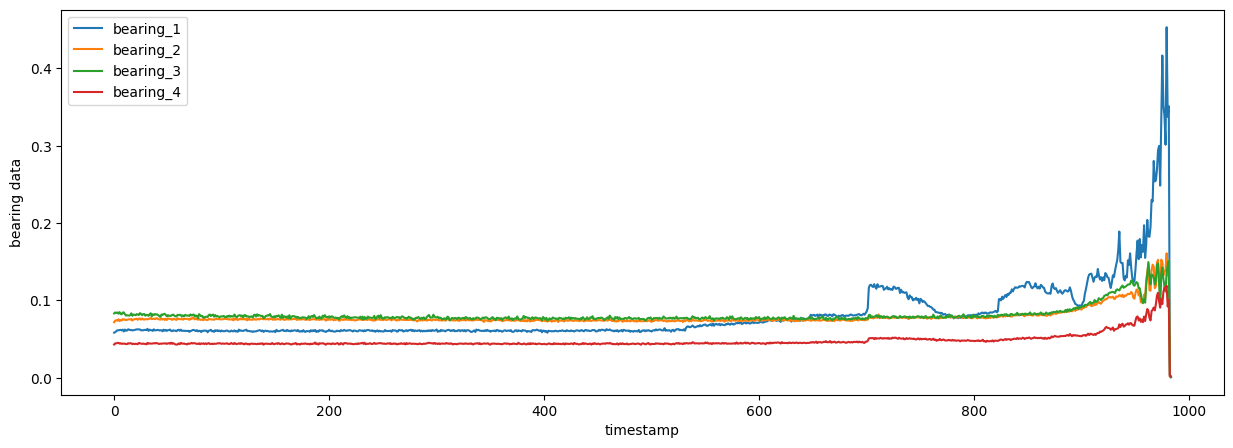

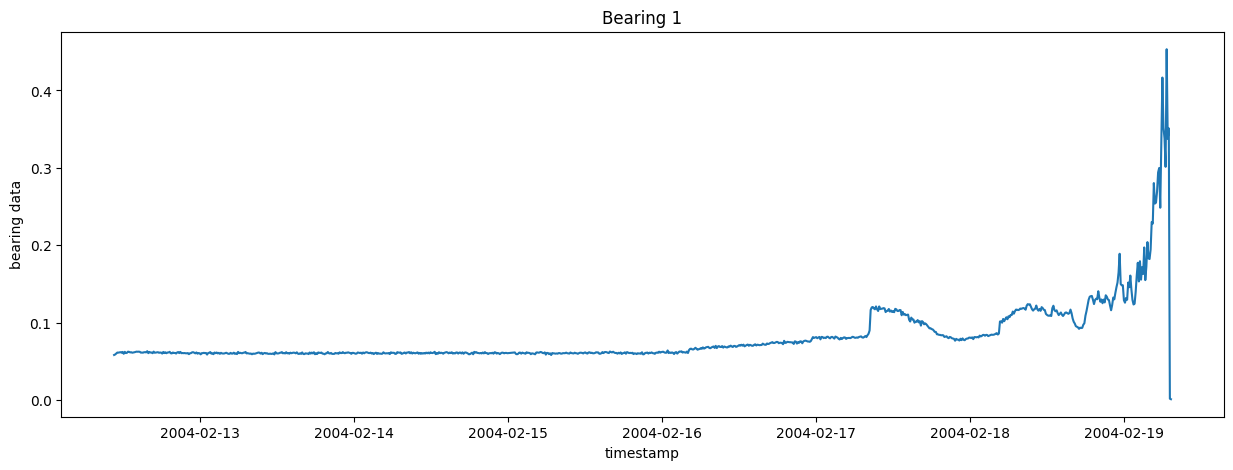

In [4]:
import matplotlib.pyplot as plt
import numpy as np

timestamps = data['timestamp']
tick_positions = np.linspace(0, len(timestamps) - 1, 5).astype(int)
tick_labels = timestamps.iloc[tick_positions]

plt.figure(figsize=(15, 5))
plt.plot(data['bearing_1'])
plt.plot(data['bearing_2'])
plt.plot(data['bearing_3'])
plt.plot(data['bearing_4'])
plt.xlabel('timestamp')
plt.ylabel('bearing data')
plt.legend(['bearing_1', 'bearing_2', 'bearing_3', 'bearing_4'])
plt.show()

# plot the bearing 1
plt.figure(figsize=(15, 5))
plt.plot(data['timestamp'], data['bearing_1'])
plt.xlabel('timestamp')
plt.ylabel('bearing data')
plt.title('Bearing 1')
plt.show()


#### 2.1.3 Conclusão
O banco de dados descreve que na amostra 2 (Set No. 2) que ao final do experimento ocorreu uma falha no rolamento 01 (bearing 01). Como podemos ver no gráfico, o rolamento 01 apresenta variações perto do final da serie temporal. Um aumento constante nos níveis de vibração, podem indicar desgaste e deterioração dos rolamentos. Identificar essas tendências ajuda a prever falhas iminentes e a planejar a manutenção preventiva.


### 2.2 Pergunta Analítica 2 - Evidência de Avanço
- **Pergunta:** Existe alguma correlação significativa entre as diferentes medições?


#### 2.2.1 Hipótese
Existe uma correlação significativa entre as diferentes medições.

#### 2.2.2 Tabelas - Código

In [5]:
# Numeric columns
numeric_columns = ['bearing_1', 'bearing_2', 'bearing_3', 'bearing_4']

# Calculate the correlation matrix
correlation_matrix = data[numeric_columns].corr()

# Show the correlation matrix
correlation_matrix


,bearing_1,bearing_2,bearing_3,bearing_4
bearing_1,1.000000,0.887926,0.807621,0.945133
bearing_2,0.887926,1.000000,0.965273,0.963390
bearing_3,0.807621,0.965273,1.000000,0.907860
bearing_4,0.945133,0.963390,0.907860,1.000000


#### 2.2.3 Gráficos - Diagramas

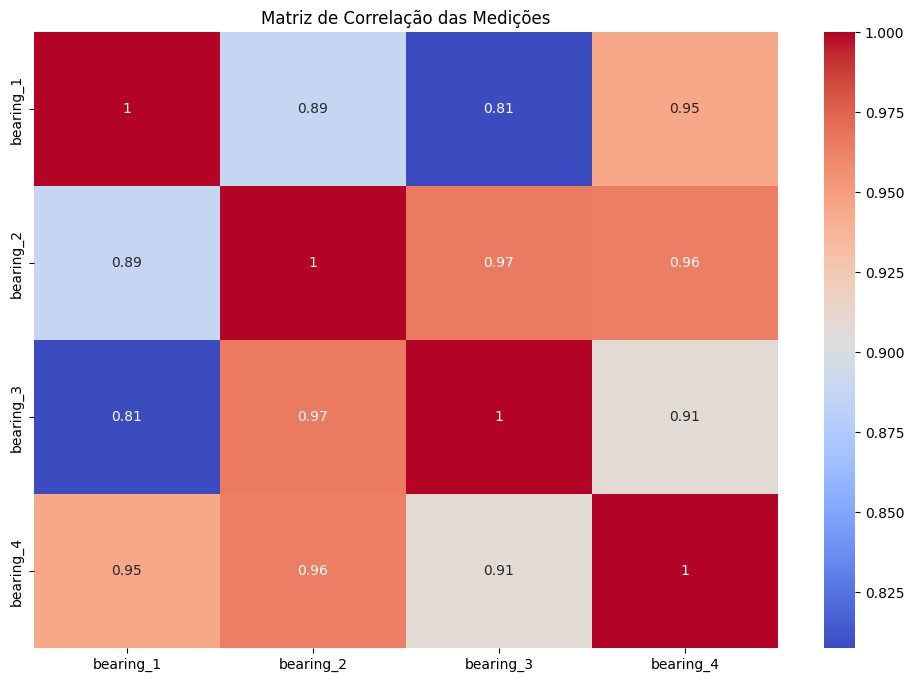

In [6]:

import seaborn as sns

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação das Medições')
plt.show()


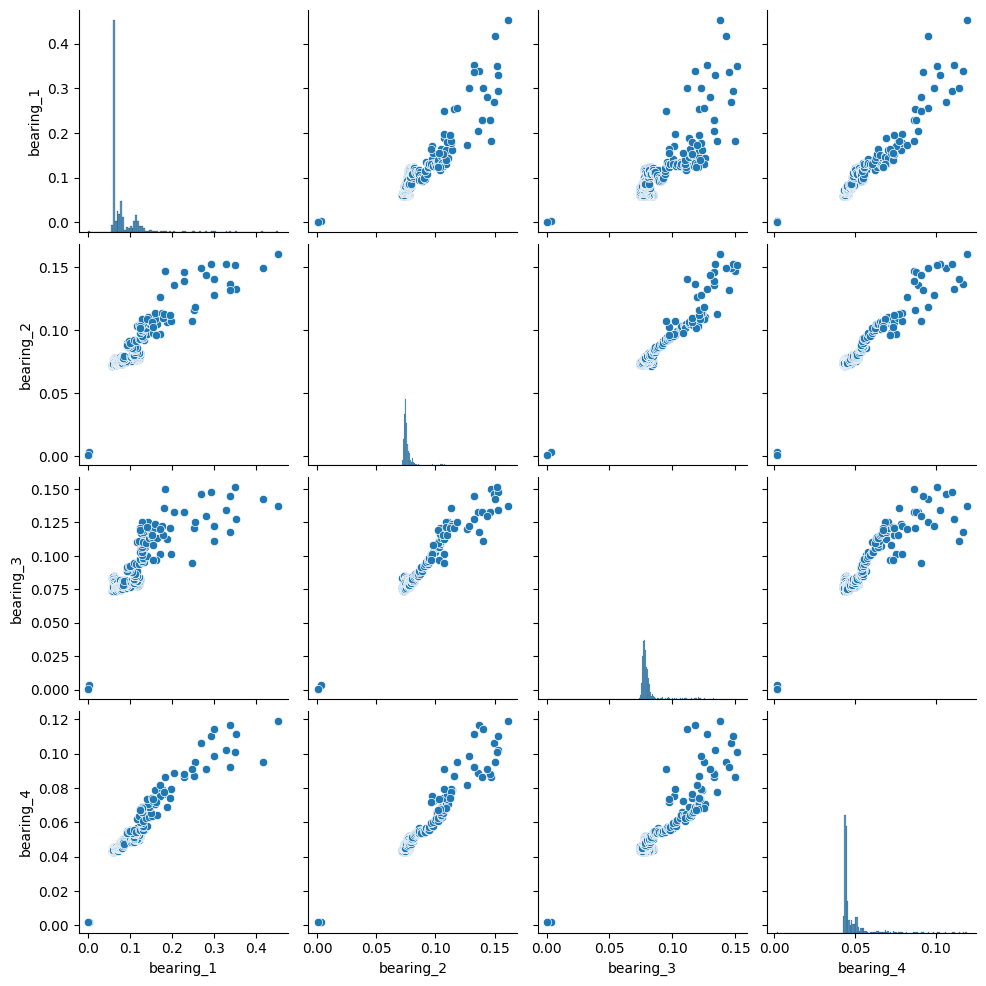

In [7]:
# Plot correlations agains each other
sns.pairplot(data[numeric_columns])
plt.show()

#### 2.2.4 Conclusão
Como podemos observar os dados de cada rolamento estão altamente correlacionados. Isso leva a hipótese de que a falha ou variação dos dados um rolamento tem efeito sobre sobre os demais. Podemos identificar padroes utilizando apenas uma das variaveis uma vez que não temos muita variancia entre os dados.


### 2.3 Pergunta Analítica 3 - Detecção de Anomalias
- **Pergunta:**  Existem padrões de vibração que se destacam como anômalos e podem indicar uma falha iminente?


#### 2.3.1 Hipótese
Existem padroes capazes de identificar anomalias nos dados

#### 2.3.2 Tabelas - Código

In [8]:
from sklearn.ensemble import IsolationForest

# Selecionar as colunas de vibração para a análise
vibration_data = data[['bearing_1', 'bearing_2', 'bearing_3', 'bearing_4']]

# Treinar o modelo de Isolation Forest
model = IsolationForest(contamination=0.01)  # Ajustar a taxa de contaminação conforme necessário
model.fit(vibration_data)

# Predizer anomalias
data['anomaly'] = model.predict(vibration_data)
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})  # Mapear 1 para normal e -1 para anomalia

# Exibir as anomalias detectadas
anomalies = data[data['anomaly'] == 1]
print(anomalies)

                     timestamp  bearing_1  bearing_2  bearing_3  bearing_4  \
970  2004-02-19 04:12:39-03:00   0.269331   0.149215   0.146111   0.106215   
971  2004-02-19 04:22:39-03:00   0.294224   0.152526   0.147829   0.109945   
974  2004-02-19 04:52:39-03:00   0.329175   0.152799   0.134074   0.102279   
975  2004-02-19 05:02:39-03:00   0.416710   0.149928   0.142589   0.095363   
976  2004-02-19 05:12:39-03:00   0.351936   0.132495   0.127523   0.111187   
977  2004-02-19 05:22:39-03:00   0.338250   0.136768   0.118167   0.116861   
978  2004-02-19 05:32:39-03:00   0.301368   0.140430   0.111463   0.114493   
979  2004-02-19 05:42:39-03:00   0.453318   0.161011   0.137444   0.119042   
980  2004-02-19 05:52:39-03:00   0.337575   0.132397   0.144997   0.092123   
981  2004-02-19 06:02:39-03:00   0.351094   0.152259   0.151296   0.100813   

     anomaly  
970        1  
971        1  
974        1  
975        1  
976        1  
977        1  
978        1  
979        1  
980   

#### 2.3.3 Gráficos - Diagramas

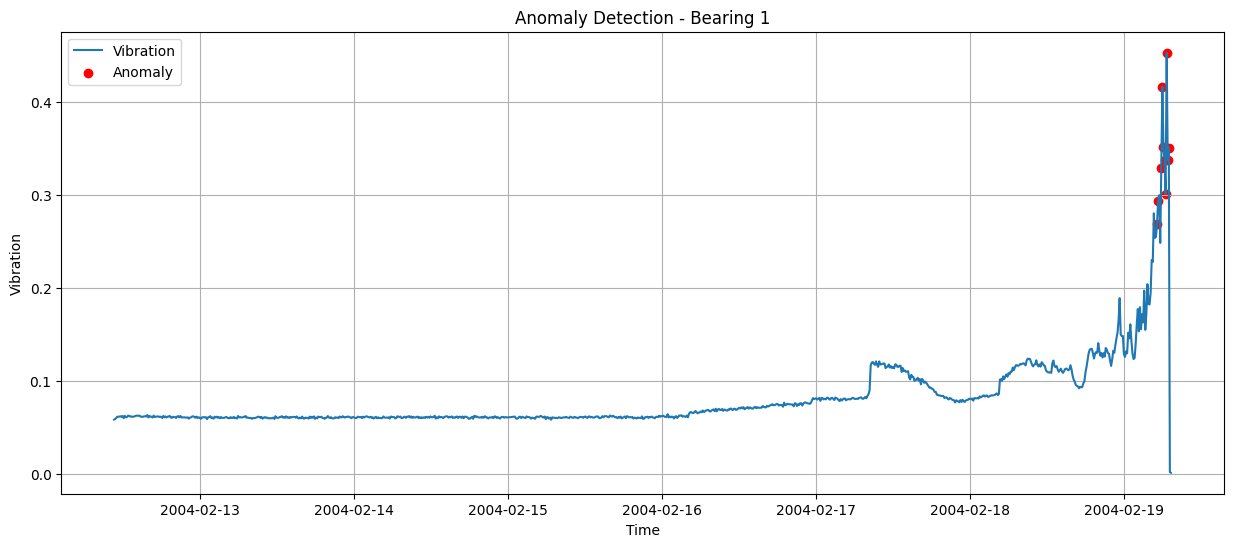

In [9]:
# Plotar as anomalias detectadas ao longo do tempo
plt.figure(figsize=(15, 6))
plt.plot(data['timestamp'], data['bearing_1'], label='Vibration')
plt.scatter(anomalies['timestamp'], anomalies['bearing_1'], color='red', label='Anomaly')
plt.title('Anomaly Detection - Bearing 1')
plt.xlabel('Time')
plt.ylabel('Vibration')
plt.legend()
plt.grid(True)
plt.show()

#### 2.3.4 Conclusão
A detecção de anomalias pode identificar padrões de vibração incomuns que indicam problemas emergentes nos rolamentos. A analise utilizando o modelo Isolation Forest foi capaz de identificar anomalias que indicam falhas dentro dos rolamentos. conforme especificado no documento do banco de dados as falhas ocorreram perto do final (teste ate a falha).

In [10]:
# Turn each entry into a cycle
data['cycle'] = range(1, len(data) + 1)

In [11]:
data.head()

,timestamp,bearing_1,bearing_2,bearing_3,bearing_4,anomaly,cycle
0,2004-02-12 10:32:39-02:00,0.058332,0.071832,0.083244,0.043065,0,1
1,2004-02-12 10:42:39-02:00,0.058997,0.074008,0.084439,0.044540,0,2
2,2004-02-12 10:52:39-02:00,0.060239,0.074223,0.083922,0.044442,0,3
3,2004-02-12 11:02:39-02:00,0.061453,0.073843,0.084462,0.045081,0,4
4,2004-02-12 11:12:39-02:00,0.061361,0.075606,0.082837,0.045118,0,5


### 2.4 Pergunta Analítica 4 - Detecção de Anomalias 02
- **Pergunta:**  Podemos identificar padroes utilizando PCA?

#### 2.4.1 Tabelas - Código

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select numeric columns
numeric_columns = ['bearing_1', 'bearing_2', 'bearing_3', 'bearing_4']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Apply PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df["timestamp"] = data["timestamp"]

# Show the DataFrame with the principal components
pca_df.head()

,PC1,PC2,timestamp
0,-0.738373,-0.450559,2004-02-12 10:32:39-02:00
1,-0.506281,-0.521886,2004-02-12 10:42:39-02:00
2,-0.509082,-0.478307,2004-02-12 10:52:39-02:00
3,-0.453714,-0.465708,2004-02-12 11:02:39-02:00
4,-0.445440,-0.415823,2004-02-12 11:12:39-02:00


#### 2.4.2 Graficos - Diagramas

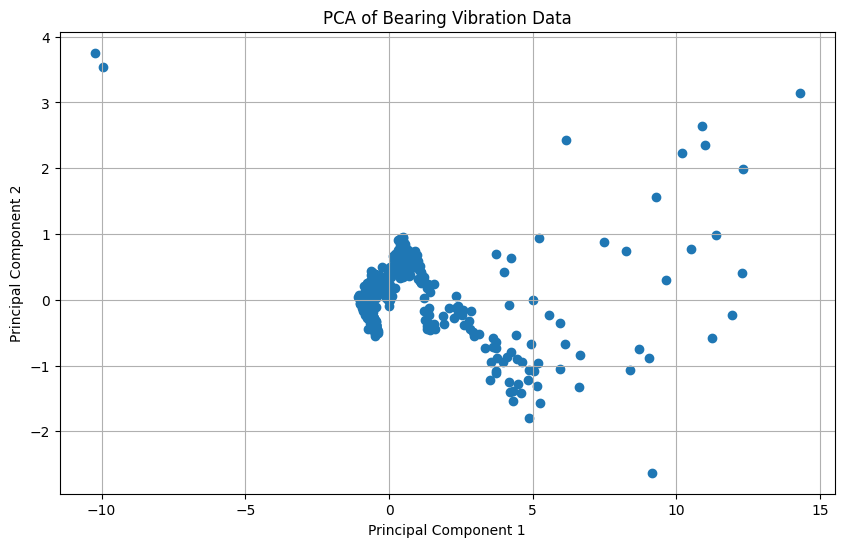

In [15]:
import matplotlib.pyplot as plt

# Plotar os componentes principais
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('PCA of Bearing Vibration Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

#### 2.4.3 Conclusão
Pontos que se afastam das distribuições típicas nos gráficos de PCA podem indicar anomalias ou condições de falha iminente, permitindo uma intervenção proativa.